# Forest Height Computation

© Sami Ahola, 2021

This notebook demonstrates how to compute forest height using open source libraries and open data. Open data consists of *National Land Survey Finland*'s laser scanning, orthogonal and elevation datas.

NLS Finland's open data is licensed "Attribution 4.0 International (CC BY 4.0)". This notebook contains data from the National Land Survey of Finland Topographic, Elevation and Laser Scanning Database. Data was acquired from the database during 2021/08-09.

Finnish Meteorological Institute open data Hirlam Weather Model is licensed by [CC BY 4.0](http://en.ilmatieteenlaitos.fi/open-data-licence) and was acquired during 2021/08. 

## Data Collection

### Location

In [1]:
# Area of interest lies in map tile R4311 (TM35 map grid == karttalehtijako)

orto_map_tile = "R4311C"
lidar_map_tile = "R4311C2"

In [2]:
# Compute tm35fin coordinates

from ext import tm35fin

get_tile_corners = lambda tile: {corner: tm35fin.xy_of_tile(tile, corner) for corner in ["nw", "se"]}
orto_corners = get_tile_corners(orto_map_tile)
lidar_corners = get_tile_corners(lidar_map_tile)

orto_corners, lidar_corners

({'nw': (410000, 7152000), 'se': (416000, 7146000)},
 {'nw': (410000, 7152000), 'se': (413000, 7149000)})

In [6]:
# Plot areas on map. Need to transform to latlon for Folium.

import folium
from pyproj import Transformer

transformer = Transformer.from_crs("etrs-tm35fin(E,N)", "EPSG:4326")
orto_corners_latlon = {k: transformer.transform(*v) for k, v in orto_corners.items()}
lidar_corners_latlon = {k: transformer.transform(*v) for k, v in lidar_corners.items()}

m = folium.Map(location=[64.4783, 25.1888], zoom_start=7, min_zoom=5, max_zoom=18)
m.add_child(folium.Marker([64.4783, 25.1888], popup="<i>Area of Interest.</i>", tooltip="Click Rectangles"))
m.add_child(folium.Rectangle(bounds=orto_corners_latlon.values(), tooltip="R4311C", popup="orto", color="#3186cc", fill=True, fill_color="#3186cc"))
m.add_child(folium.Rectangle(bounds=lidar_corners_latlon.values(), tooltip="R4311C2", popup="lidar", color="#FFFF00", fill=True, fill_color="#FFFF00"))
m

### Lidar Point Cloud Data

In [4]:
import laspy

f = laspy.open("/mnt/DATA_SSD/portfolio/nls/R4311C2.laz")
las = f.read()

In [5]:
import numpy as np

# Scale XYZ variables
scales = {d: s for d, s in zip("XYZ", f.header.scales)}
# Create numpy array of the points
points = las.points
#arr = np.array(list(zip(points.Y * scales['Y'], points.X * scales['X'], points.Z * scales['Z'])))
points_arr = np.vstack((points.X * scales['X'], points.Y * scales['Y'], points.Z * scales['Z'])).transpose()

In [6]:
import pandas as pd

# Move data to Pandas DataFrame for processing and review it 
df_lidar_all = pd.DataFrame(points_arr, columns=["E", "N", "Z"])
df_lidar_all

E           N      Z
0         410000.02  7150492.46  80.63
1         410000.02  7150460.44  80.55
2         410000.00  7150453.98  80.38
3         410000.00  7150423.70  80.66
4         410000.01  7150403.92  98.84
...             ...         ...    ...
17292992  410800.62  7151999.93  76.22
17292993  410796.81  7151999.93  85.73
17292994  410800.29  7151999.92  76.24
17292995  410796.94  7151999.91  84.42
17292996  410799.89  7151999.90  76.36

[17292997 rows x 3 columns]

In [7]:
# Reindex lidar data to 2m granularity

granularity = 2  # meters

E = np.arange(lidar_corners['nw'][0], lidar_corners['se'][0] + granularity, granularity)
N = np.arange(lidar_corners['se'][1], lidar_corners['nw'][1] + granularity, granularity)
df_lidar_all['N_group'] = pd.cut(df_lidar_all['N'], N, labels=N[:-1], include_lowest=True)
df_lidar_all['E_group'] = pd.cut(df_lidar_all['E'], E, labels=E[:-1], include_lowest=True)

In [8]:
# Make the new granularity the index for array

df_lidar_all = df_lidar_all.drop(["N","E"], axis=1).dropna()
df_lidar_all.set_index(["N_group", "E_group"], inplace=True)
df_lidar_all.sort_index(inplace=True)

In [9]:
# Double check the index composition

df_lidar_all.index

MultiIndex([(7149000, 410000),
            (7149000, 410000),
            (7149000, 410000),
            (7149000, 410000),
            (7149000, 410002),
            (7149000, 410002),
            (7149000, 410002),
            (7149000, 410002),
            (7149000, 410002),
            (7149000, 410002),
            ...
            (7151998, 412992),
            (7151998, 412994),
            (7151998, 412994),
            (7151998, 412996),
            (7151998, 412996),
            (7151998, 412996),
            (7151998, 412998),
            (7151998, 412998),
            (7151998, 412998),
            (7151998, 412998)],
           names=['N_group', 'E_group'], length=17292997)

In [10]:
# Check if index is unique, which is important for furthere processing.

df_lidar_all.index.is_unique

False

In [11]:
# Index is not unique, which means that there are multiple points inside one grid cell. Group them to keep the mean Z value.
# Future improvement could be to select highest intensity return.

df_lidar_grid = df_lidar_all.groupby(['N_group', 'E_group']).max()

In [12]:
# Check again if index is unique.

df_lidar_grid.index.is_unique

True

In [13]:
# Let's check if there is data for whole area or if there are gaps in Z data.
# We can see that there are missing data.

df_lidar_grid.isna().sum()

Z    11011
dtype: int64

In [14]:
# Move from Pandas DataFrame to Xarray DataArray for better grid handling.

da_lidar_grid = df_lidar_grid.to_xarray()['Z']
da_lidar_grid

<xarray.DataArray 'Z' (N_group: 1500, E_group: 1500)>
array([[83.41, 86.83, 85.1 , ..., 90.38, 91.84, 95.68],
       [88.4 , 86.93, 83.86, ..., 92.24, 86.66, 88.77],
       [85.8 , 87.31, 84.9 , ..., 86.42, 86.56, 87.03],
       ...,
       [87.01, 86.21, 86.02, ..., 78.42, 78.76, 74.61],
       [77.11, 87.12, 87.54, ..., 80.38, 79.45, 78.95],
       [83.72, 85.54, 85.4 , ..., 79.84, 81.11, 80.54]])
Coordinates:
  * N_group  (N_group) int64 7149000 7149002 7149004 ... 7151994 7151996 7151998
  * E_group  (E_group) int64 410000 410002 410004 ... 412994 412996 412998

In [15]:
# Calculate the percentage of missing values in grid.

float(da_lidar_grid.isnull().sum() / da_lidar_grid.count())

0.004917844616476454

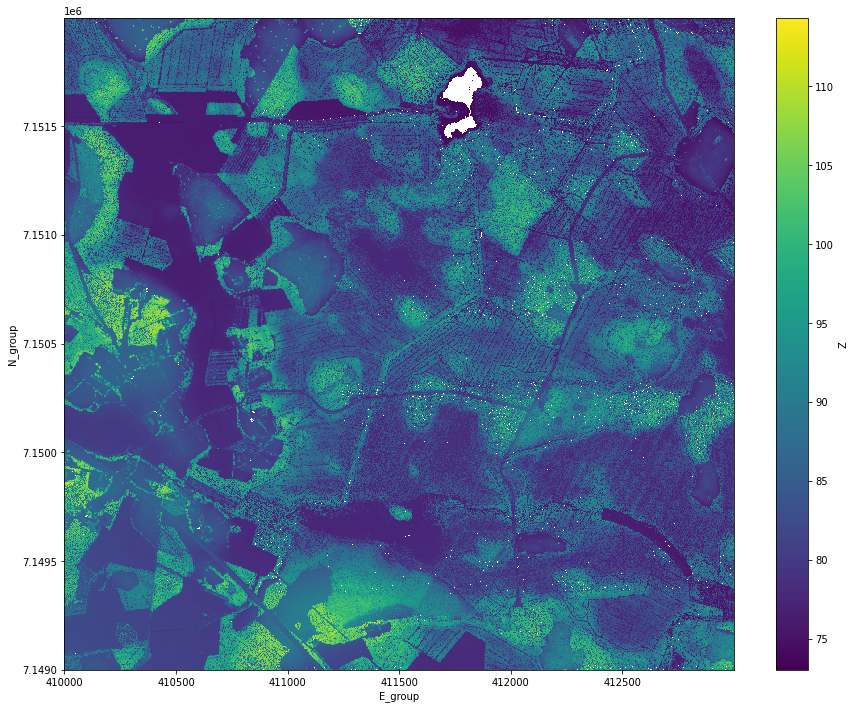

In [16]:
import xarray as xr

da_lidar_grid.plot(figsize=(15, 12))

In [17]:
da_lidar_grid = da_lidar_grid.rename({"E_group": "E", "N_group": "N"})

In [18]:
da_lidar_grid

<xarray.DataArray 'Z' (N: 1500, E: 1500)>
array([[83.41, 86.83, 85.1 , ..., 90.38, 91.84, 95.68],
       [88.4 , 86.93, 83.86, ..., 92.24, 86.66, 88.77],
       [85.8 , 87.31, 84.9 , ..., 86.42, 86.56, 87.03],
       ...,
       [87.01, 86.21, 86.02, ..., 78.42, 78.76, 74.61],
       [77.11, 87.12, 87.54, ..., 80.38, 79.45, 78.95],
       [83.72, 85.54, 85.4 , ..., 79.84, 81.11, 80.54]])
Coordinates:
  * N        (N) int64 7149000 7149002 7149004 ... 7151994 7151996 7151998
  * E        (E) int64 410000 410002 410004 410006 ... 412994 412996 412998

### Ortho Images

### Load Raster Data

In [19]:
# Load image data

from PIL import Image

img = Image.open("/mnt/DATA_SSD/portfolio/nls/R4311C.jp2")
img.format, img.size, img.mode

/home/samia/.virtualenvs/portfolio/lib/python3.9/site-packages/PIL/Image.py:2911: DecompressionBombWarning: Image size (144000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


('JPEG2000', (12000, 12000), 'RGB')

In [20]:
# Transform from PIL to Numpy

import numpy as np

arr = np.asarray(img)
arr.shape

(12000, 12000, 3)

In [21]:
# Transform from Numpy to Xarray DataArray

import xarray

# Compute coordinates in all dimensions
E = np.linspace(orto_corners['nw'][0], orto_corners['se'][0], arr.shape[0], endpoint=False)
N = np.linspace(orto_corners['se'][1], orto_corners['nw'][1], arr.shape[1], endpoint=False)
channels = list("RGB")

da_ortho = xarray.DataArray(np.flipud(arr).swapaxes(1, 0),
                            coords={"E": E, "N": N, "channel": channels},
                            dims=["E", "N", "channel"])

# Downsample to 2m grid for compatibility with 2m lidar data
da_ortho = da_ortho.coarsen({'E': 4, 'N': 4}, coord_func='min').mean().astype('int')

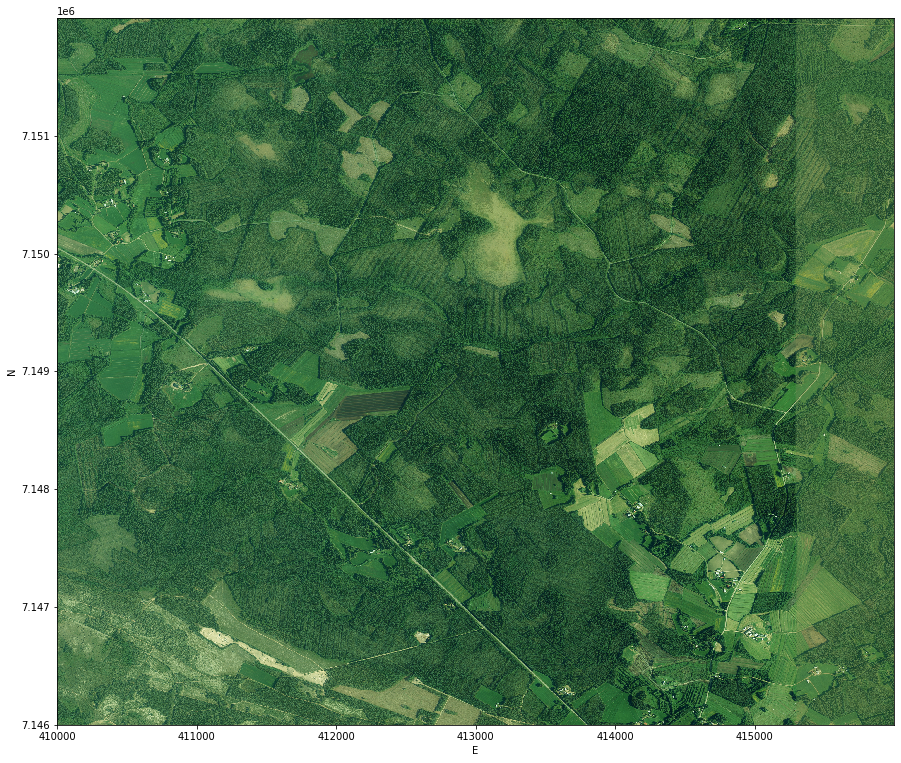

In [22]:
da_ortho.plot.imshow(x='E', y='N', figsize=(15,13))

### Load Map Tile Function

In [23]:
from pathlib import Path
import numpy as np
from PIL import Image
import xarray

def load_tile(file_path, map_tile: str = None) -> xarray.DataArray:
    map_tile = map_tile or Path(file_path).stem
    corners = get_tile_corners(map_tile)
    img = Image.open(file_path)
    arr = np.asarray(img)
    E = np.linspace(corners['nw'][0], corners['se'][0], arr.shape[0], endpoint=False)
    N = np.linspace(corners['se'][1], corners['nw'][1], arr.shape[1], endpoint=False)
    coords = {"E": E, "N": N}
    dims = ["E", "N"]
    if Path(file_path).suffix == ".jp2":
        coords.update({"channel": channels})
        dims.append("channel")
    da = xarray.DataArray(np.flipud(arr).swapaxes(0, 1),
                          coords=coords,
                          dims=dims)
    return da

### Load All Images

In [24]:
raster_files = {
    "orto": "/mnt/DATA_SSD/portfolio/nls/R4311C.jp2",
    "elevation": "/mnt/DATA_SSD/portfolio/nls/R4311C.tif"
}

da_images = {name: load_tile(filename) for name, filename in raster_files.items()}

/home/samia/.virtualenvs/portfolio/lib/python3.9/site-packages/PIL/Image.py:2911: DecompressionBombWarning: Image size (144000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


### Weather

In [25]:
import xarray as xr

ds = xr.open_dataset("/mnt/DATA_SSD/portfolio/numerical-hirlam74-forecast-Temperature-20210826T060000Z.grb2", engine='cfgrib')
ds

<xarray.Dataset>
Dimensions:            (step: 55, latitude: 947, longitude: 5294)
Coordinates:
    time               datetime64[ns] ...
  * step               (step) timedelta64[ns] 00:00:00 ... 2 days 06:00:00
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 25.65 25.72 25.78 ... 89.86 89.93 90.0
  * longitude          (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
    valid_time         (step) datetime64[ns] ...
Data variables:
    t2m                (step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-02T18:59 GRIB to CDM+CF via cfgrib-0.9.9...

In [26]:
da = ds["t2m"]
da

<xarray.DataArray 't2m' (step: 55, latitude: 947, longitude: 5294)>
[275737990 values with dtype=float32]
Coordinates:
    time               datetime64[ns] 2021-08-26T06:00:00
  * step               (step) timedelta64[ns] 00:00:00 ... 2 days 06:00:00
    heightAboveGround  float64 2.0
  * latitude           (latitude) float64 25.65 25.72 25.78 ... 89.86 89.93 90.0
  * longitude          (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
    valid_time         (step) datetime64[ns] 2021-08-26T06:00:00 ... 2021-08-...
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            af
    GRIB_numberOfPoints:                      5013418
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

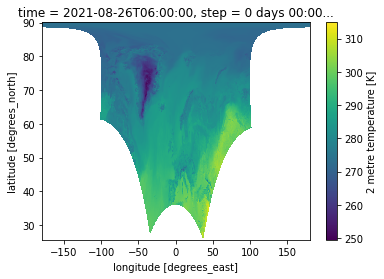

In [27]:
da.isel(step=0).plot()

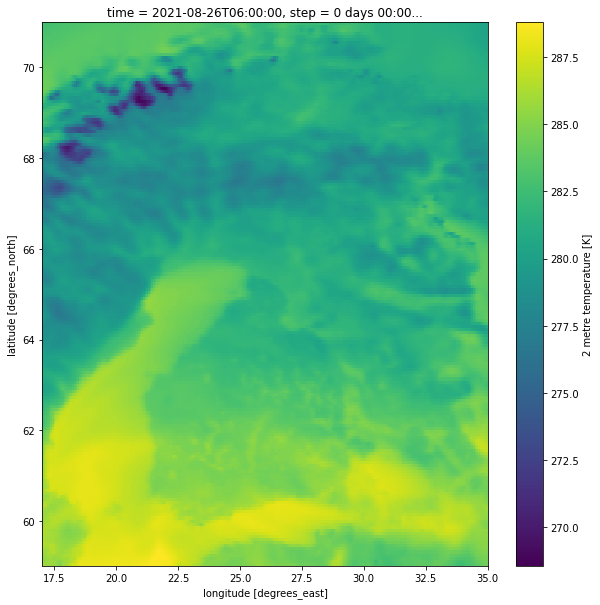

In [28]:
da_fin = da.isel(step=0).sel(latitude=slice(59,71), longitude=slice(17, 35))
da_fin.plot(aspect=1, size=10)

In [29]:
#TODO: Download whole month, calculate total precipitation and max wind

### Combine Collected Data to Dataset

In [30]:
ds = xarray.Dataset(da_images)
ds = ds.coarsen({'E': 4, 'N': 4}, coord_func='min').mean()
ds["orto"] = ds.orto.astype(np.uint8)

In [31]:
ds = ds.assign({"lidar": da_lidar_grid})

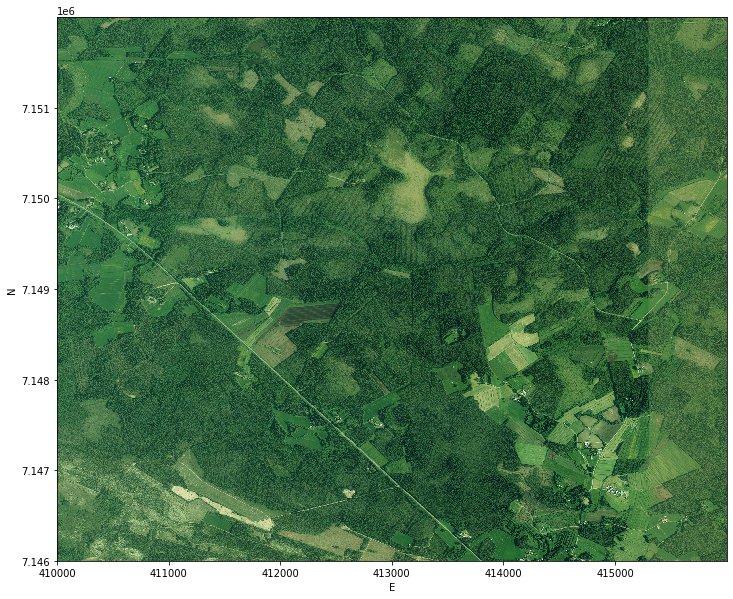

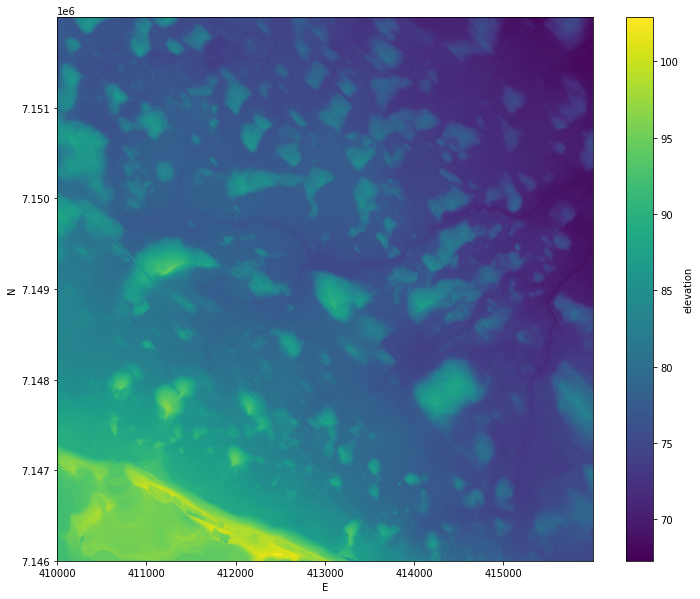

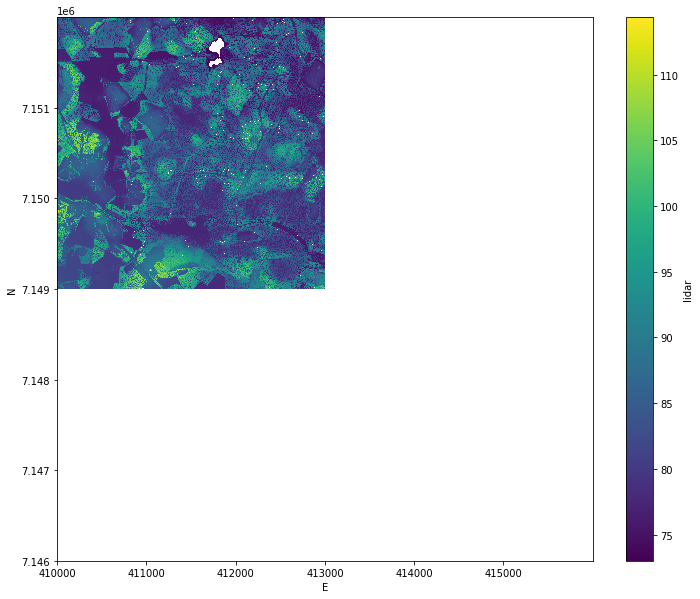

In [32]:
ds.orto.plot.imshow(x='E', y='N', figsize=(12,10))
ds.elevation.plot.imshow(x='E', y='N', figsize=(12,10))
ds.lidar.plot.imshow(figsize=(12,10))

## Compute Forest Height

### Subtract elevation values from lidar height data to create forest height raster.

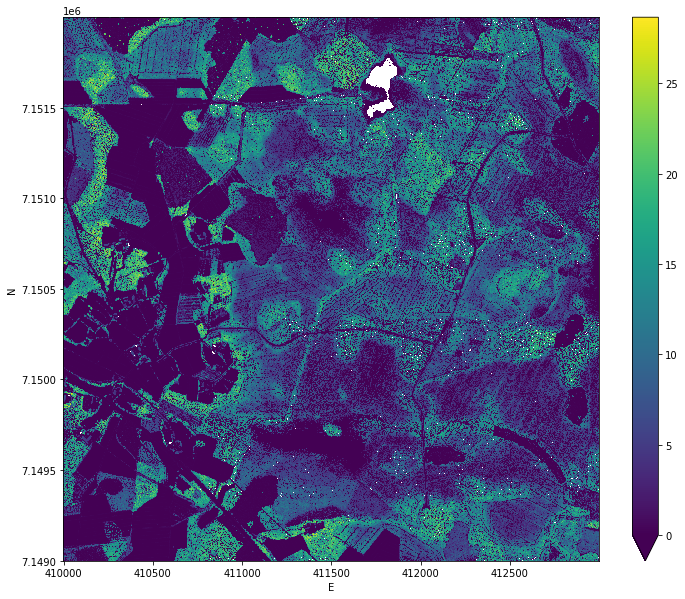

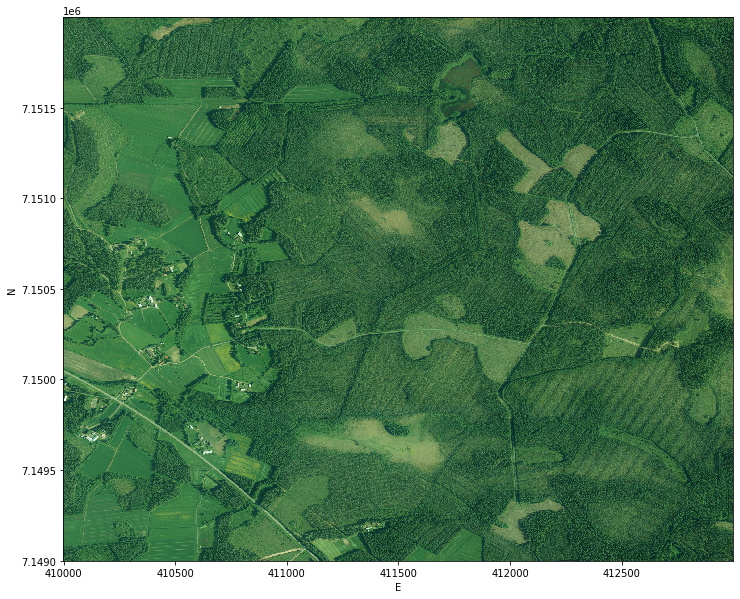

In [42]:
# Compute tree heights. Crop to the area covered by lidar data.

bbox = dict(N=slice(7149000, 7152000), E=slice(410000, 412999))

da_tree_height = (ds.lidar - ds.elevation).sel(**bbox)
da_orto = ds.orto.sel(**bbox)

da_tree_height.plot.imshow(cmap="viridis", vmin=0, figsize=(12, 10))
da_orto.plot.imshow(x='E', y='N', figsize=(12,10))